# __Group Assignment__

__Submission Date:__ 26/03/2025

__Assignment: NLP-2024-2025: Assignment 1__

__Group Members:__
- ANZALONE Gabriel
- MBENGUE Ndèye Arame

__Firm level topic of discussion:__ Technological Disruption

__Task__ : Measuring <u>Technological Disruption</u> with transcripts of Conference Calls.

# <u>**Preliminaries**</u>

#### <b><u>Data Preparation and Text Cleaning</b></u>

In [2]:
# Code for Github
!pip install pyarrow

In [3]:
# Code for Github
! pip install nltk

In [4]:
# Code for Github
!pip install statsmodels

#### <b><u>Loading data</b></u>

<b><u>Comment:</b></u>
- We decided to analyze both Management Presentations and Q&A Sessions here to ensure a certain level of robustness to our different measures.
- The aim being to capture both the prepared narratives on Technological Disruption and the spontaneous mentions of it.

In [5]:
import pandas as pd

In [6]:
# Let's import Earnings Calls and Q&A sessions of S&P500 from 2015 to 2021
Sample_EC = pd.read_csv("https://www.dropbox.com/scl/fi/2p7ahxroqj9pwf98ni5an/Sample_Calls.csv?rlkey=zfieicvz891u4e3z0aroeg0u7&dl=1")
Sample_Presentations = pd.read_feather("https://www.dropbox.com/scl/fi/uceh2xva5g4apbmt92cgt/Sample_Calls_Presentations.feather?rlkey=ln4nzsa4nenqyvm0pg2cur9sp&dl=1")
Sample_QAs = pd.read_feather("https://www.dropbox.com/scl/fi/iq4111nlmsykp2tzxk9xg/Sample_Calls_QA.feather?rlkey=xabjqmwhesx05jivrlfzkgj6m&dl=1")

In [7]:
Sample_Presentations.head()

,file_name,presentation
0,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016...,Good day and welcome to the Linear Technol...
1,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016...,Welcome to Cerner Corporation's first quar...
2,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016...,Welcome to Cerner Corporation's second qua...
3,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016...,Welcome to Cerner Corporation's third quar...
4,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2017...,Welcome to Cerner Corporation's fourth qua...


In [8]:
Sample_QAs.head()

,QA,speaker_name,file_name,QA_text,QA_number
0,q,david wong,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016...,"Thanks very much. Don, could you give us some ...",1
1,a,don zerio,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016...,"Yes, David, as you know we retired our convert...",1
2,q,david wong,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016...,"Great, thanks.",2
3,q,craig hettenbach,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016...,Great thank you. Just a question on the commen...,3
4,a,lothar maier,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016...,"When you think about China you know, particula...",3


#### <b><u>Filtering data</b></u>

In [9]:
temp = Sample_QAs[Sample_QAs['QA'] == 'a'] # keeping only the answers & aggregating them by file name
temp = temp.groupby('file_name')['QA_text'].apply(lambda x: ' '.join(x)).reset_index()
Sample_answers = Sample_EC.merge(temp) # merging it into the main df

In [10]:
Sample_answers

,GVKEY,date_rdq,co_conm,file_name,CAR-11-Carhart,CAR-11-ff3,CAR01-Carhart,CAR01-ff3,IV,hvol,...,niq,epspxq,epspiq,dlttq,dlcq,prccq,cshoq,dvpq,xintq,QA_text
0,16101.0,2016-07-29 13:00:00+00:00,ABBVIE INC,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016...,0.011886,0.014261,0.014261,0.021246,0.179151,0.129186,...,1610.0,0.99,0.99,37328.0,517.0,61.91,1628.542,0.0,245.0,"Jeff, this is Rick. I will cover the first and..."
1,16101.0,2016-04-28 13:00:00+00:00,ABBVIE INC,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016...,0.026387,0.023499,0.023499,0.021770,0.289777,0.114447,...,1354.0,0.83,0.83,29490.0,2423.0,57.12,1617.359,0.0,215.0,"Okay. Hi, Jeff, it's Rick. So I'll take I gues..."
2,16101.0,2016-10-28 13:00:00+00:00,ABBVIE INC,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016...,-0.078668,-0.079290,-0.079290,-0.092594,0.253269,0.381002,...,1598.0,0.97,0.97,37284.0,26.0,63.07,1624.908,0.0,271.0,"Sure, Jami; this is Rick. Thank you for the qu..."
3,16101.0,2017-01-27 14:00:00+00:00,ABBVIE INC,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2017...,-0.010152,-0.000737,-0.000737,-0.005279,0.182080,0.145941,...,1391.0,0.85,0.85,36440.0,402.0,62.62,1592.513,0.0,277.0,"Hi, Jami; it's Bill. So on your operating marg..."
4,16101.0,2017-04-27 13:00:00+00:00,ABBVIE INC,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2017...,0.010397,0.010672,0.010672,0.012819,0.192822,0.112189,...,1711.0,1.07,1.07,36526.0,425.0,65.16,1591.366,0.0,273.0,"Yes. Well, first, thanks for the question. May..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2872,189491.0,2016-11-01 13:00:00+00:00,XYLEM INC,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016...,-0.022716,-0.023069,-0.023069,-0.015313,0.238038,0.176583,...,73.0,0.41,0.41,1148.0,62.0,52.45,179.400,0.0,12.0,"Yes, well, thanks for the question, Jim. First..."
2873,189491.0,2016-08-02 13:00:00+00:00,XYLEM INC,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016...,-0.036201,-0.034737,-0.034737,-0.037363,0.201698,0.213624,...,71.0,0.39,0.39,1143.0,91.0,44.65,179.200,0.0,12.0,"Sure, Deane. Let me just characterize what we ..."
2874,189491.0,2020-07-30 13:00:00+00:00,XYLEM INC,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2020...,-0.030116,-0.028020,-0.028020,-0.049431,0.325614,0.345711,...,31.0,0.17,0.17,3031.0,269.0,64.96,180.000,0.0,18.0,"That is correct, Dean, on both counts. Sure. Y..."
2875,189491.0,2018-05-01 13:00:00+00:00,XYLEM INC,Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2018...,-0.066260,-0.064927,-0.064927,-0.058477,0.206359,0.215869,...,79.0,0.44,0.44,2228.0,371.0,76.92,179.500,0.0,21.0,"Yes, I'll go first here, Nate. And I think the..."


In [11]:
# Filtering Presentations
Sample_Presentations = Sample_Presentations[
    Sample_Presentations['presentation'].str.split().apply(len) > 50 #  we keep presentations with at least 50 words -> remove noise
].reset_index(drop=True)

Pres = Sample_Presentations.groupby("file_name")["presentation"].agg(lambda x: " ".join(x)).reset_index() # and we also group by file name
Pres.columns= ["file_name","text"]

#### <b><u>Preprocessing Data</b></u>

<u>Comment:</u>
- We want to remove stopwords, break data into different tokens and lemmatize so as to have a common ground for our different measures.

In [12]:
#  We import the necessary librairies
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [13]:
# We first remove the stopwords, put everything in lowercase and break it into tokens
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    tokens = word_tokenize(text.lower()) # putting all in lowercase format
    tokens = [word for word in tokens if word.isalnum() and word not in stop_words]
    return tokens

Pres['tokens'] = Pres['text'].apply(preprocess_text)
Sample_answers['tokens'] = Sample_answers['QA_text'].apply(preprocess_text) # both for presentation & Q&A

In [14]:
# Then we lemmatize to have a unified format of wording

lemmatizer = WordNetLemmatizer()

def lemmatize_text(tokens):
    return [lemmatizer.lemmatize(token) for token in tokens]

Pres['tokens'] = Pres['tokens'].apply(lemmatize_text)
Sample_answers['tokens'] = Sample_answers['tokens'].apply(lemmatize_text)

In [15]:
Pres['tokens'].head(10)

,tokens
0,"[lady, gentleman, thank, standing, welcome, fi..."
1,"[welcome, prudential, quarterly, earnings, cal..."
2,"[lady, gentleman, thank, standing, welcome, pr..."
3,"[lady, gentleman, thank, standing, welcome, q1..."
4,"[lady, gentleman, thank, standing, welcome, q2..."
5,"[thank, tom, good, morning, everyone, welcome,..."
6,"[welcome, southwest, airline, second, quarter,..."
7,"[thank, tom, good, morning, everyone, welcome,..."
8,"[lady, gentleman, thank, standing, welcome, an..."
9,"[lady, gentleman, thank, standing, welcome, an..."


In [16]:
Sample_answers['tokens'].head(10)

,tokens
0,"[jeff, rick, cover, first, third, one, mike, c..."
1,"[okay, hi, jeff, rick, take, guess, question, ..."
2,"[sure, jami, rick, thank, question, think, loo..."
3,"[hi, jami, bill, operating, margin, question, ..."
4,"[yes, well, first, thanks, question, maybe, le..."
5,"[okay, jami, thanks, much, question, try, take..."
6,"[okay, mike, maybe, start, talking, rate, cove..."
7,"[right, jami, rick, first, thank, compliment, ..."
8,"[right, thanks, jami, rick, appreciate, questi..."
9,"[rick, take, first, question, mike, cover, sec..."


# <u>**Measures: Analysis & Market Reaction**</u>

We decided to compare 3 different measures to see which one was better capturing Technological Disruption among the Earnings Calls:
- Naïve method: frequency count
- Tf-idf weighted scheme
- Embeddings & Cosine similarity

### __1- Intuitive (Naïve) method__

#### __1.1 - Presentation Focus__

##### <u><b>Computing the score</u></b>

In [17]:
# We start with our proper set of Tech dictionnary words related to technological disruption

tech_dict = [
    "disrupt", "disruption",
    "innovate", "innovation",
    "digitize", "digital",
    "automation", "automate",
    "artificial", "intelligence",
    "machine", "learning",
    "blockchain", "cyber",
    "robot", "iot", "tech"
]

In [18]:
# We compute the tech score: counting the number of tech words in each transcript
# And divide it by the length of this transcript

def tech_score(tokens, tech_words):
    if len(tokens) == 0: # case = 0
        return 0
    count = sum(1 for token in tokens if token in tech_words)
    return count / len(tokens)

In [19]:
# We first get a set of tech scores for every presentations
Pres['tech_score'] = Pres['tokens'].apply(lambda tokens: tech_score(tokens, tech_dict))
print(Pres[['file_name', 'tech_score']].head(10))

                                           file_name  tech_score
0  Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016...    0.000000
1  Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016...    0.000000
2  Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016...    0.000000
3  Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016...    0.001849
4  Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016...    0.002694
5  Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016...    0.000000
6  Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016...    0.000000
7  Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016...    0.000000
8  Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016...    0.000000
9  Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016...    0.000000


##### <u><b>Aggregating by Quarter & by Firm</u></b>

<u>Comment:</u>
- We want to relate every tech_score to its firm and its earnings quarter.

In [20]:
# We merge the Presentation with the principles of firms (names & other columns)
merged = pd.merge(
    Pres,
    Sample_EC[['file_name', 'GVKEY', 'co_conm', 'date_rdq', 'CAR-11-Carhart', 'SurpDec', 'IV']],
    on='file_name',
    how='left'
)

# Grouping by quarter
merged['date_rdq'] = pd.to_datetime(merged['date_rdq'])
merged['quarter'] = merged['date_rdq'].dt.to_period('Q')
firm_quarter = merged.groupby(['co_conm', 'quarter'])['tech_score'].mean().reset_index()

print(firm_quarter.head())

      co_conm quarter  tech_score
0  ABBVIE INC  2016Q2    0.000327
1  ABBVIE INC  2016Q3    0.000000
2  ABBVIE INC  2016Q4    0.000000
3  ABBVIE INC  2017Q1    0.000000
4  ABBVIE INC  2017Q2    0.000000


<ipython-input-20-09f247ca1303>:11: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  merged['quarter'] = merged['date_rdq'].dt.to_period('Q')


<u>Comment:</u>
- Now we have a set: for each firm, its tech_score per quarter.

##### <u><b>Sorting Firms by their Tech Score</u></b>

<u>Comment:</u>
- We can rank the firms quarterly based on their tech_score.
- And have the Top 10 firms more exposed to Technological Disruption & the Bottom 10.
- Based on words frequency.

In [21]:
# If we sort by descending order
sorted_firms = firm_quarter.sort_values(by='tech_score', ascending=False)
print("Top firms with high technological disruption score:")
print(sorted_firms.head(10))

print("\nFirms with low technological disruption score:")
print(sorted_firms.tail(10))

Top firms with high technological disruption score:
                       co_conm quarter  tech_score
622   COGNIZANT TECH SOLUTIONS  2017Q4    0.029772
621   COGNIZANT TECH SOLUTIONS  2017Q3    0.029437
619   COGNIZANT TECH SOLUTIONS  2017Q1    0.026060
624   COGNIZANT TECH SOLUTIONS  2018Q2    0.024725
1828           NIKE INC  -CL B  2020Q4    0.024182
620   COGNIZANT TECH SOLUTIONS  2017Q2    0.023854
625   COGNIZANT TECH SOLUTIONS  2018Q3    0.023284
1827           NIKE INC  -CL B  2020Q3    0.021989
623   COGNIZANT TECH SOLUTIONS  2018Q1    0.021947
1821           NIKE INC  -CL B  2019Q1    0.021900

Firms with low technological disruption score:
                    co_conm quarter  tech_score
449    CABOT OIL & GAS CORP  2017Q3         0.0
448    CABOT OIL & GAS CORP  2017Q2         0.0
447    CABOT OIL & GAS CORP  2017Q1         0.0
446    CABOT OIL & GAS CORP  2016Q4         0.0
445    CABOT OIL & GAS CORP  2016Q3         0.0
444    CABOT OIL & GAS CORP  2016Q2         0.0
782

<u>Comment:</u>
- This is quite logical: tech companies in the Top 10 (although Nike is not really operating in the Tech sector) & Healthcare and Beverage Companies in the Bottom 10.

##### <u><b>Aggregate Trend Over Time</u></b>

<u>How does Technological Disruption debate evolve over time ? </u>

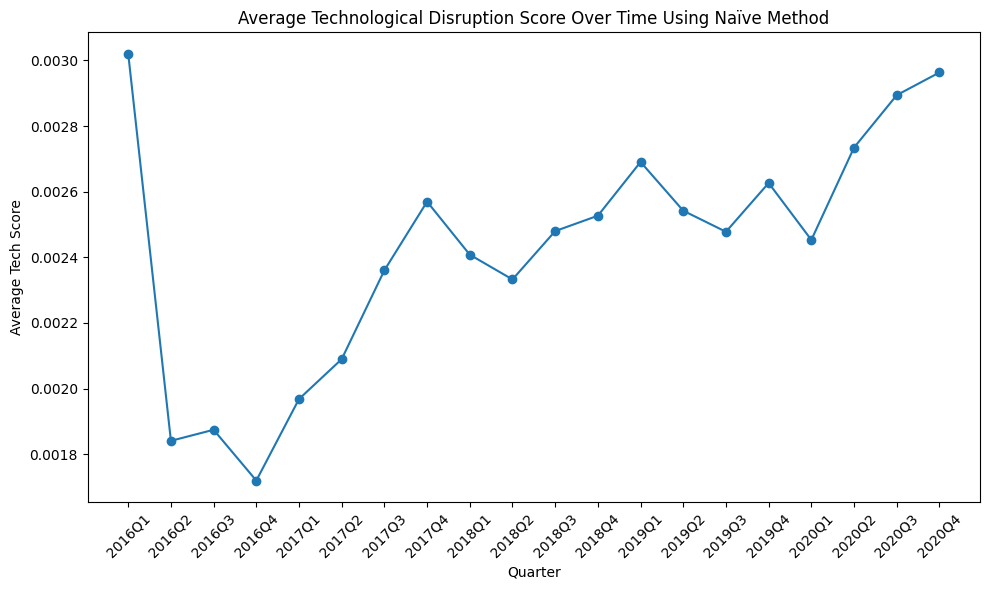

In [22]:
import matplotlib.pyplot as plt

agg_quarter = merged.groupby('quarter')['tech_score'].mean().reset_index()
agg_quarter['quarter_str'] = agg_quarter['quarter'].astype(str)
plt.figure(figsize=(10,6))
plt.plot(agg_quarter['quarter_str'], agg_quarter['tech_score'], marker='o', linestyle='-')
plt.xticks(rotation=45)
plt.title("Average Technological Disruption Score Over Time Using Naïve Method")
plt.xlabel("Quarter")
plt.ylabel("Average Tech Score")
plt.grid(False)
plt.tight_layout()
plt.show()

<u>Comment:</u>
- We observe a peak on the first quarter (Q1 2016) and then a sudden drop (average tech_score almost slashed by 2 in only one quarter).
- Then an increasing average tech_score to peak again at the end of period.

##### <u><b>Technological Disruption & Market Reaction</u></b>

<u>Comment:</u>

- We use market reaction variable: CAR-11-Carhart from the main df.
- Objective: observe whether firm discussing technological disruption are more keen to experience different market reactions.

In [23]:
import statsmodels.api as sm

analysis_data = merged.dropna(subset=['CAR-11-Carhart', 'tech_score'])

# Independent & dependent variables
X = analysis_data[['tech_score']]
y = analysis_data['CAR-11-Carhart']

X = sm.add_constant(X)

# We fit the OLS regression model
ols_model = sm.OLS(y, X).fit()
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:         CAR-11-Carhart   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     3.342
Date:                Tue, 25 Mar 2025   Prob (F-statistic):             0.0676
Time:                        08:21:55   Log-Likelihood:                 3894.3
No. Observations:                2816   AIC:                            -7785.
Df Residuals:                    2814   BIC:                            -7773.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0020      0.001     -1.390      0.1

<u>Comment:</u>
- Low R-Squared: 0.001 -> tech_score is not a strong predictor of CAR-11-Carhart here...
- High p-value (0.068 > 0.05) -> we do not observe statistical significance.
- So no strong evidence of tech_score effect on market reaction with this measure.

##### <u><b>Adding other Control Variables</u></b>

<u> What if we add the earnings surprise & implied volatility to the regression ? </u>

In [24]:
analysis_data = merged.dropna(subset=['CAR-11-Carhart', 'tech_score', 'SurpDec', 'IV'])

control_vars = ['tech_score', 'SurpDec', 'IV'] # adding the 2 control variables
X = analysis_data[control_vars]
y = analysis_data['CAR-11-Carhart']

X = sm.add_constant(X)

model_controls = sm.OLS(y, X).fit()
print(model_controls.summary())

                            OLS Regression Results                            
Dep. Variable:         CAR-11-Carhart   R-squared:                       0.068
Model:                            OLS   Adj. R-squared:                  0.067
Method:                 Least Squares   F-statistic:                     67.52
Date:                Tue, 25 Mar 2025   Prob (F-statistic):           3.89e-42
Time:                        08:21:55   Log-Likelihood:                 3937.7
No. Observations:                2772   AIC:                            -7867.
Df Residuals:                    2768   BIC:                            -7844.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0056      0.003     -1.828      0.0

<u>Comment:</u>

- Higher R-Squared (0.068 > 0.001) -> better explanation of CAR-11-Carhart (but still very low).
- Low overall p-value (3.89e-42) -> at least one control variable explains  CAR-11-Carhart.
- It clearly seems to be the Earnings Surprise, with a p-value of 0.

#### __1.2- Q&A Focus__

##### <u><b>Computing the score</u></b>

In [25]:
# Computing the tech_score within the Q&A
Sample_answers['tech_score_qa'] = Sample_answers['tokens'].apply(lambda tokens: tech_score(tokens, tech_dict))
print("Sample Q&A Tech Scores:")
print(Sample_answers[['file_name', 'tech_score_qa']].head(10))

Sample Q&A Tech Scores:
                                           file_name  tech_score_qa
0  Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016...       0.000000
1  Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016...       0.000000
2  Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016...       0.000445
3  Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2017...       0.000433
4  Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2017...       0.000360
5  Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2017...       0.000344
6  Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2017...       0.000000
7  Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2018...       0.000000
8  Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2018...       0.001038
9  Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2018...       0.000000


##### <u><b>Aggregating by Quarter</u></b>

In [26]:
Sample_answers['date_rdq'] = pd.to_datetime(Sample_answers['date_rdq'])
Sample_answers['quarter'] = Sample_answers['date_rdq'].dt.to_period('Q')

agg_qa = Sample_answers.groupby('quarter')['tech_score_qa'].mean().reset_index()
agg_qa['quarter_str'] = agg_qa['quarter'].astype(str)

print("Quarterly Aggregated Q&A Tech Scores:")
print(agg_qa.head())

Quarterly Aggregated Q&A Tech Scores:
  quarter  tech_score_qa quarter_str
0  2016Q1       0.003426      2016Q1
1  2016Q2       0.001830      2016Q2
2  2016Q3       0.002078      2016Q3
3  2016Q4       0.002146      2016Q4
4  2017Q1       0.002204      2017Q1


<ipython-input-26-4e8a82bafa01>:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  Sample_answers['quarter'] = Sample_answers['date_rdq'].dt.to_period('Q')


##### <u><b>Plotting Q&A tech_score vs Presentation tech_score</u></b>

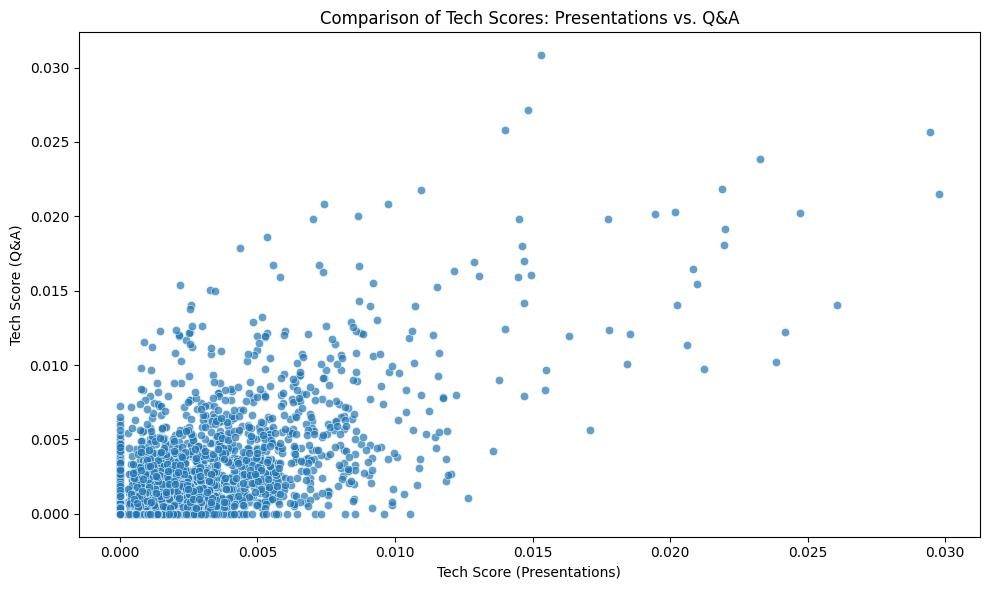

In [27]:
import seaborn as sns
merged_tech = pd.merge(Pres[['file_name', 'tech_score']],
                       Sample_answers[['file_name', 'tech_score_qa']],
                       on='file_name', how='inner')

plt.figure(figsize=(10,6))
sns.scatterplot(data=merged_tech, x='tech_score', y='tech_score_qa', alpha=0.7)
plt.xlabel("Tech Score (Presentations)")
plt.ylabel("Tech Score (Q&A)")
plt.title("Comparison of Tech Scores: Presentations vs. Q&A")
plt.grid(False)
plt.tight_layout()
plt.show()

<u>Comment:</u>

- Vast majority of tech_scores both very close to zero.
- Very few presentations  & Q&A contain the tech_dict words actually.
- Some points with higher Q&A scores than presentation -> Q&A sometimes more technology-focused.

##### <u><b>Plotting the trend over time</u></b>

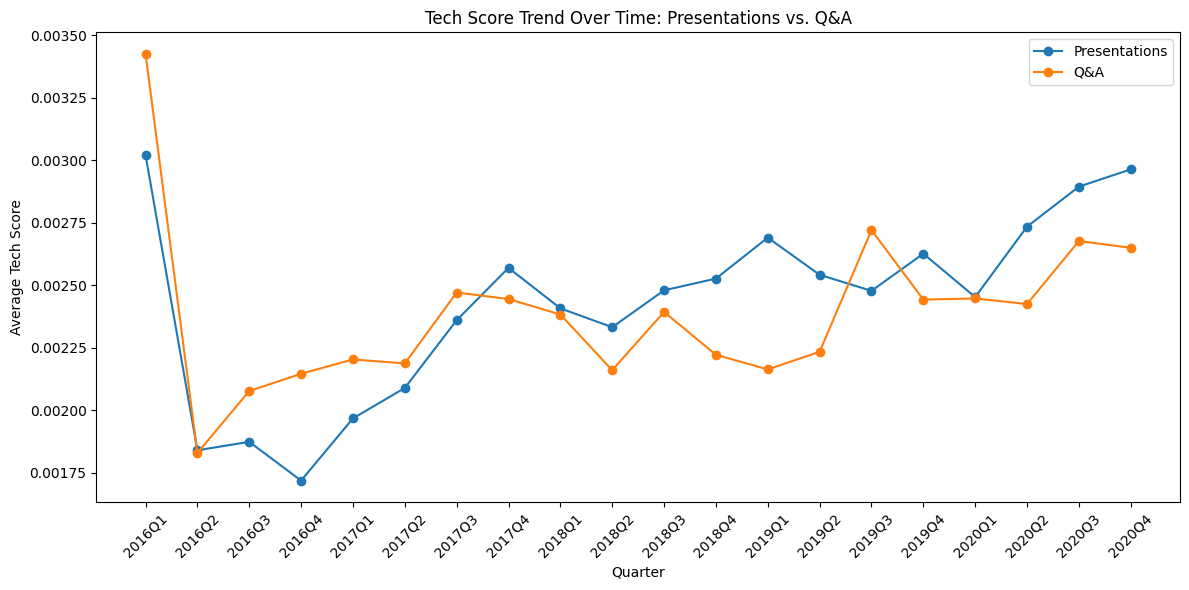

In [28]:
plt.figure(figsize=(12,6))
plt.plot(agg_quarter['quarter_str'], agg_quarter['tech_score'], marker='o', label='Presentations')
plt.plot(agg_qa['quarter_str'], agg_qa['tech_score_qa'], marker='o', label='Q&A')
plt.xticks(rotation=45)
plt.xlabel("Quarter")
plt.ylabel("Average Tech Score")
plt.title("Tech Score Trend Over Time: Presentations vs. Q&A")
plt.legend()
plt.tight_layout()
plt.show()

<u>Commment:</u>
- Both display a strong initial decline and an increase over time thereafter.
- Seems like technology-related discussions have become more prevalent over time.
- Presentation tech-scores generally above the Q&A -> a focus mostly concentrated on official and prepared discussions.

### __2- TF-IDF Weigted Count__

<u>Comment:</u>

- Here we weigh words by how unique they are in the corpus.
- TF-IDF actually reduces the impact of very common words.

#### __2.1- Presentation Focus__

##### <u><b>Computing the tech_score with TF-IDF</u></b>

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer

# We have to join tokens back into text to use TF-IDF processing
Pres['joined_text'] = Pres['tokens'].apply(lambda tokens: ' '.join(tokens))
Sample_answers['joined_text'] = Sample_answers['tokens'].apply(lambda tokens: ' '.join(tokens))

# We still use our bag of technology-related words
vectorizer = TfidfVectorizer(vocabulary=tech_dict)

# Compute TF-IDF scores both for presentations & Q&A
tfidf_pres_matrix = vectorizer.fit_transform(Pres['joined_text'])
Pres['tfidf_score'] = tfidf_pres_matrix.sum(axis=1).A1  # Sum scores across your vocab
tfidf_qa_matrix = vectorizer.fit_transform(Sample_answers['joined_text'])
Sample_answers['tfidf_score_qa'] = tfidf_qa_matrix.sum(axis=1).A1

##### <u><b>Aggregating by Quarter & by Firm</u></b>

In [30]:
# Merge with firm metadata
merged_tfidf = pd.merge(
    Pres[['file_name', 'tfidf_score']],
    Sample_EC[['file_name', 'GVKEY', 'co_conm', 'date_rdq', 'CAR-11-Carhart', 'SurpDec', 'IV']],
    on='file_name',
    how='left'
)

merged_tfidf['date_rdq'] = pd.to_datetime(merged_tfidf['date_rdq'])
merged_tfidf['quarter'] = merged_tfidf['date_rdq'].dt.to_period('Q')
firm_quarter_tfidf = merged_tfidf.groupby(['co_conm', 'quarter'])['tfidf_score'].mean().reset_index()

<ipython-input-30-92385ee3f1c7>:10: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  merged_tfidf['quarter'] = merged_tfidf['date_rdq'].dt.to_period('Q')


##### <u><b>Sorting Firms on Their Tech Score</u></b>

In [31]:
top_tfidf_firms = firm_quarter_tfidf.sort_values(by='tfidf_score', ascending=False)
print("Firms with highest TF-IDF scores:", top_tfidf_firms.head(10))
print("Firms with lowest TF-IDF scores:", top_tfidf_firms.tail(10))

Firms with highest TF-IDF scores:                    co_conm quarter  tfidf_score
2837   XEROX HOLDINGS CORP  2020Q4     2.828875
2831   XEROX HOLDINGS CORP  2019Q2     2.780587
520            CERNER CORP  2019Q3     2.747011
2330    SALESFORCE.COM INC  2018Q4     2.738036
2828   XEROX HOLDINGS CORP  2018Q3     2.718418
896            EQUIFAX INC  2020Q4     2.694062
2746  WESTERN DIGITAL CORP  2019Q1     2.671104
889            EQUIFAX INC  2019Q1     2.562800
2103   PROCTER & GAMBLE CO  2017Q3     2.561165
2102   PROCTER & GAMBLE CO  2017Q2     2.542086
Firms with lowest TF-IDF scores:                            co_conm quarter  tfidf_score
1108                     HESS CORP  2017Q4          0.0
1109                     HESS CORP  2018Q1          0.0
1110                     HESS CORP  2018Q2          0.0
1111                     HESS CORP  2018Q3          0.0
1112                     HESS CORP  2018Q4          0.0
586   CITIZENS FINANCIAL GROUP INC  2018Q1          0.0
1113         

<u>Comment:</u>
- We observe technology-related firms in the Top 10: Salesforce, Xerox, Cerner but also consumption goods firms like P&G...
- Bottom 10 is composed of firms operating in more traditional sectors (energy, transport, financials...).

##### <u><b>Aggregate Trend over time</u></b>

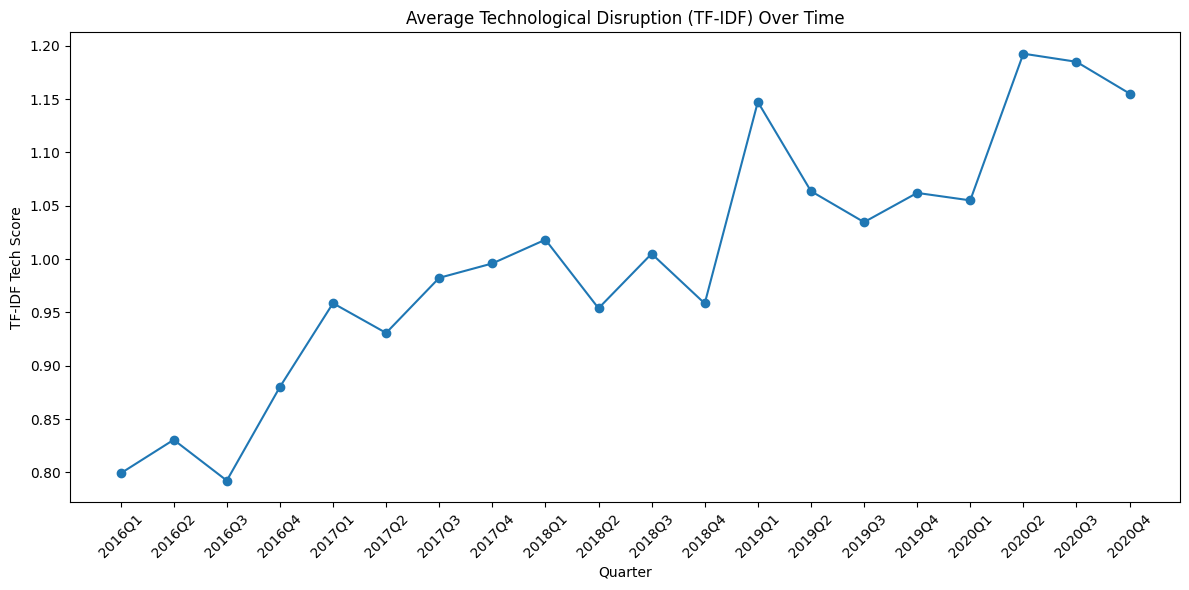

In [32]:
agg_tfidf_quarter = firm_quarter_tfidf.groupby('quarter')['tfidf_score'].mean().reset_index()
agg_tfidf_quarter['quarter_str'] = agg_tfidf_quarter['quarter'].astype(str)

import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(agg_tfidf_quarter['quarter_str'], agg_tfidf_quarter['tfidf_score'], marker='o')
plt.xticks(rotation=45)
plt.title("Average Technological Disruption (TF-IDF) Over Time")
plt.xlabel("Quarter")
plt.ylabel("TF-IDF Tech Score")
plt.tight_layout()
plt.show()

<u>Comment:</u>
- It is quite different from the Naïve Method, here we observe a constant increase in score over time.
- We do not have a sharp decline for the first quarter of the period.

##### <u><b>Technological Disruption & Market Reaction</u></b>

In [33]:
analysis_data_tfidf = merged_tfidf.dropna(subset=['CAR-11-Carhart', 'tfidf_score'])

# Independent & dependent variables
X_tfidf = analysis_data_tfidf[['tfidf_score']]
y_tf_idf = analysis_data_tfidf['CAR-11-Carhart']

X = sm.add_constant(X_tfidf)

# We fit the OLS regression model
ols_model = sm.OLS(y_tf_idf, X_tfidf).fit()
print(ols_model.summary())

                                 OLS Regression Results                                
Dep. Variable:         CAR-11-Carhart   R-squared (uncentered):                   0.000
Model:                            OLS   Adj. R-squared (uncentered):             -0.000
Method:                 Least Squares   F-statistic:                           0.003825
Date:                Tue, 25 Mar 2025   Prob (F-statistic):                       0.951
Time:                        08:22:09   Log-Likelihood:                          3892.5
No. Observations:                2816   AIC:                                     -7783.
Df Residuals:                    2815   BIC:                                     -7777.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------

<u>Comment:</u>
- R-Squared = 0 & extremely high p-value (0.951)
-Tf-idf score is not a strong predictor of CAR-11-Carhart.

##### <u><b>Adding other Control Variables</u></b>

In [34]:
# Taking into accont the tf-idf tech_score as well as other control variables
analysis_data_tfidf = merged_tfidf.dropna(subset=['CAR-11-Carhart', 'tfidf_score', 'SurpDec', 'IV'])

# Define independent variables including controls
X_tfidf = analysis_data_tfidf[['tfidf_score', 'SurpDec', 'IV']]
y_tfidf = analysis_data_tfidf['CAR-11-Carhart']

X_tfidf = sm.add_constant(X_tfidf)

# Regression
model_tfidf = sm.OLS(y_tfidf, X_tfidf).fit()
print(model_tfidf.summary())

                            OLS Regression Results                            
Dep. Variable:         CAR-11-Carhart   R-squared:                       0.068
Model:                            OLS   Adj. R-squared:                  0.067
Method:                 Least Squares   F-statistic:                     67.21
Date:                Tue, 25 Mar 2025   Prob (F-statistic):           6.02e-42
Time:                        08:22:09   Log-Likelihood:                 3937.2
No. Observations:                2772   AIC:                            -7866.
Df Residuals:                    2768   BIC:                            -7843.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0045      0.003     -1.345      

<u>What do we observe ?</u>
- Higher R-Squared.
- Small overall p-value -> statistical significance, but still mainly due to Earnings surprise.

#### __2.2- Q&A Focus__

##### <u><b>Plotting Q&A tfidf_score vs Presentation tfidf_score</u></b>

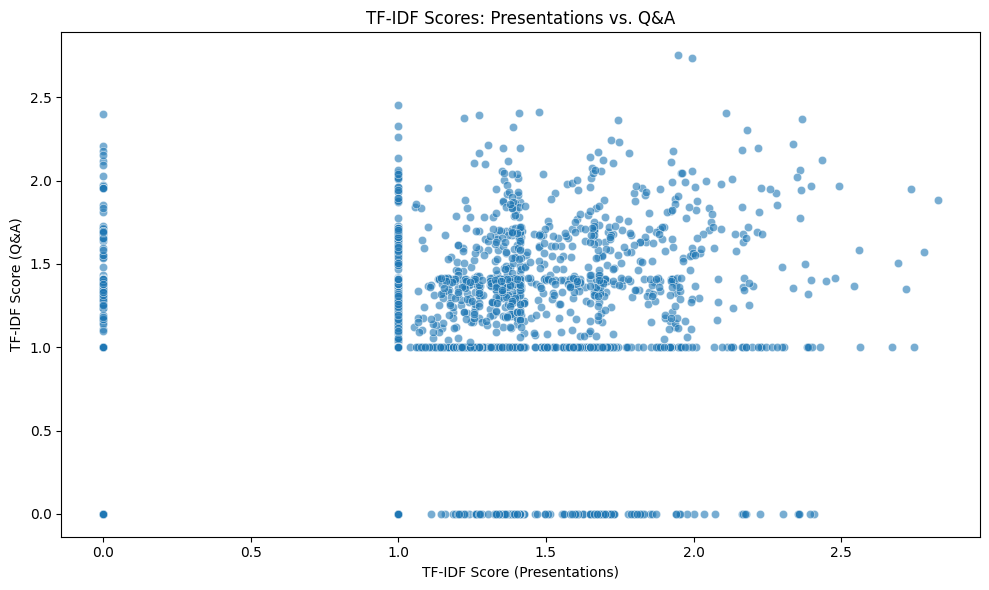

In [35]:
# Merge Presentation and Q&A TF-IDF scores
merged_tfidf_qa = pd.merge(
    Pres[['file_name', 'tfidf_score']],
    Sample_answers[['file_name', 'tfidf_score_qa']],
    on='file_name', how='inner'
)

plt.figure(figsize=(10,6))
sns.scatterplot(data=merged_tfidf_qa, x='tfidf_score', y='tfidf_score_qa', alpha=0.6)
plt.xlabel("TF-IDF Score (Presentations)")
plt.ylabel("TF-IDF Score (Q&A)")
plt.title("TF-IDF Scores: Presentations vs. Q&A")
plt.tight_layout()
plt.show()

<u>Comment:</u>
- We do not really see a pattern here.
- Most have close to 1 tf-idf score for both Q&A and presentation.
- We see both high presentation score and low Q&A score and vice-versa.
-Difficult to generalize.

### __3- Embeddings and Cosine Similarity__

<u>Comment:</u>
- Here we better capture relationships between words and semantic nuances.
- We compute an average embedding for each transcript & we measure its cosine similarity to the reference vector that we created with the Glove API.

#### __3.1- Presentation Focus__

##### <u><b>Redefining our keywords</u></b>

##### <u><b>Computing the tech score with Embeddings & Cosine Similarity</u></b>

In [38]:
import gensim.downloader as api

# Using Glove dictionnary to control our keywords
model = api.load('glove-wiki-gigaword-100')

In [39]:
from sklearn.metrics.pairwise import cosine_similarity

In [41]:
# Compute a single embedding vector representing "Technological Disruption"
# We want to see if our tech_words are in the dictionnary and compute the mean vector of these words
tech_concept_vector = np.mean(
    [model[word] for word in tech_dict if word in model],
    axis=0
)

In [42]:
#  We compute the embedding vector of a document
def doc_embedding(tokens, embedding_model):
    valid_tokens = [token for token in tokens if token in embedding_model]
    if not valid_tokens:
        return np.zeros(embedding_model.vector_size)
    return np.mean([embedding_model[token] for token in valid_tokens], axis=0)

# & Apply the function both to presentation & to Q&A
Pres['doc_embedding'] = Pres['tokens'].apply(lambda tokens: doc_embedding(tokens, model))
Sample_answers['doc_embedding'] = Sample_answers['tokens'].apply(lambda tokens: doc_embedding(tokens, model))

#  & We compute the cosine similarity
def compute_similarity(doc_vec, concept_vec):
    if np.linalg.norm(doc_vec) == 0 or np.linalg.norm(concept_vec) == 0:
        return 0.0
    return cosine_similarity([doc_vec], [concept_vec])[0][0]

Pres['embed_score'] = Pres['doc_embedding'].apply(lambda vec: compute_similarity(vec, tech_concept_vector))
Sample_answers['embed_score_qa'] = Sample_answers['doc_embedding'].apply(lambda vec: compute_similarity(vec, tech_concept_vector))

print(Pres[['file_name', 'embed_score']].head())
print(Sample_answers[['file_name', 'embed_score_qa']].head())

                                           file_name  embed_score
0  Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016...     0.523277
1  Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016...     0.540666
2  Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016...     0.530940
3  Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016...     0.562542
4  Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016...     0.568431
                                           file_name  embed_score_qa
0  Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016...        0.600953
1  Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016...        0.591506
2  Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2016...        0.594296
3  Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2017...        0.608280
4  Download ECC/SE/TRANSCRIPT/XMLStd/Archive/2017...        0.599413


##### <u><b>Aggregating by Quarter & by Firm</u></b>

In [43]:
merged_embed = pd.merge(
    Pres[['file_name', 'embed_score']],
    Sample_EC[['file_name', 'GVKEY', 'co_conm', 'date_rdq', 'CAR-11-Carhart', 'SurpDec', 'IV']],
    on='file_name', how='left'
)

merged_embed['date_rdq'] = pd.to_datetime(merged_embed['date_rdq'])
merged_embed['quarter'] = merged_embed['date_rdq'].dt.to_period('Q')
firm_quarter_embed = merged_embed.groupby(['co_conm', 'quarter'])['embed_score'].mean().reset_index()

<ipython-input-43-eaf03c3e60c0>:8: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  merged_embed['quarter'] = merged_embed['date_rdq'].dt.to_period('Q')


##### <u><b>Sorting Firms by Their Tech Score</u></b>

In [44]:
top_embed_firms = firm_quarter_embed.sort_values(by='embed_score', ascending=False)
print("Firms with highest embedding disruption scores:", top_embed_firms.head(10))
print("Firms with lowest embedding disruption scores:", top_embed_firms.tail(10))

Firms with highest embedding disruption scores:                        co_conm quarter  embed_score
1959               NVIDIA CORP  2020Q2     0.699829
622   COGNIZANT TECH SOLUTIONS  2017Q4     0.688841
1961               NVIDIA CORP  2020Q4     0.686050
1958               NVIDIA CORP  2020Q1     0.682391
1956               NVIDIA CORP  2019Q3     0.676536
616   COGNIZANT TECH SOLUTIONS  2016Q2     0.675289
620   COGNIZANT TECH SOLUTIONS  2017Q2     0.675027
204                  ANSYS INC  2019Q2     0.673916
621   COGNIZANT TECH SOLUTIONS  2017Q3     0.673904
1955               NVIDIA CORP  2019Q2     0.670988
Firms with lowest embedding disruption scores:                         co_conm quarter  embed_score
1737                NETFLIX INC  2019Q2     0.484217
2643  UNIVERSAL HEALTH SVCS INC  2017Q3     0.483953
1739                NETFLIX INC  2019Q4     0.483851
1734                NETFLIX INC  2018Q3     0.483172
2645  UNIVERSAL HEALTH SVCS INC  2018Q1     0.481316
1735           

<u>Comment:</u>
- We observe a coherent Top 10 with tech-related companies operating in the semiconductor industry.
- But we also have the presence of Netflix among the bottom 10 scores...

##### <u><b>Aggregate Trend over time</u></b>

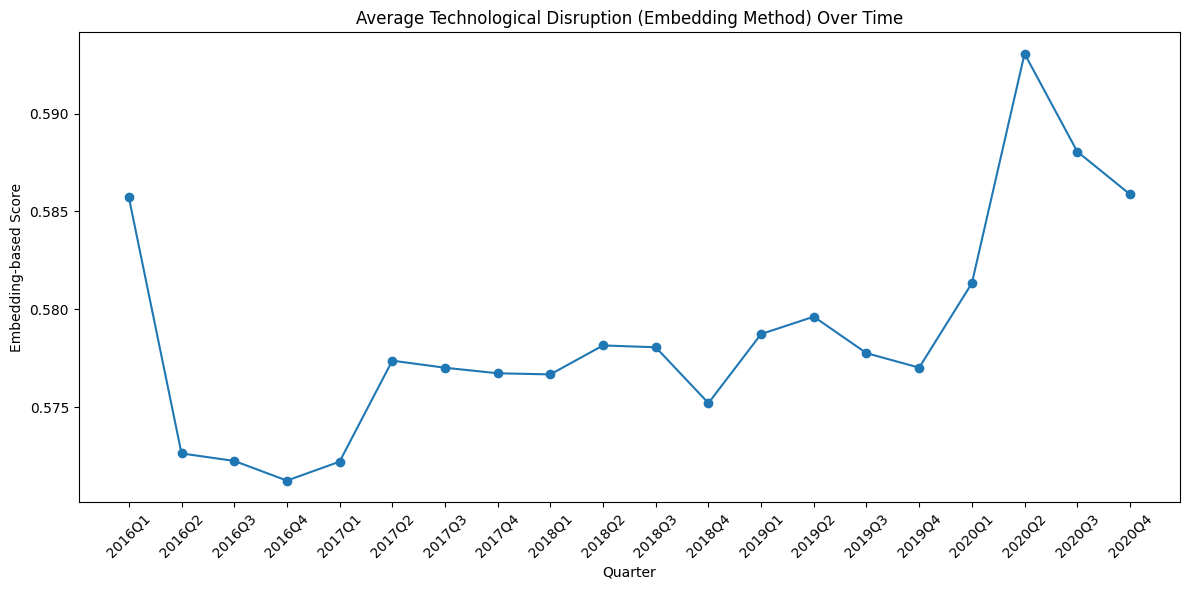

In [45]:
agg_embed_quarter = firm_quarter_embed.groupby('quarter')['embed_score'].mean().reset_index()
agg_embed_quarter['quarter_str'] = agg_embed_quarter['quarter'].astype(str)

plt.figure(figsize=(12,6))
plt.plot(agg_embed_quarter['quarter_str'], agg_embed_quarter['embed_score'], marker='o')
plt.xticks(rotation=45)
plt.title("Average Technological Disruption (Embedding Method) Over Time")
plt.xlabel("Quarter")
plt.ylabel("Embedding-based Score")
plt.tight_layout()
plt.show()

<u>Comment:</u>
- Similarly to the Naïve tech_score, we observe a sharp decline at the beginning and an increase thereafter.

##### <u><b>Technological Disruption & Market Reaction</u></b>

In [46]:
analysis_data_embed = merged_embed.dropna(subset=['CAR-11-Carhart', 'embed_score'])

X_embed = analysis_data_embed[['embed_score']]
y_embed = analysis_data_embed['CAR-11-Carhart']

X_embed = sm.add_constant(X_embed)

# Regression analysis
model_embed = sm.OLS(y_embed, X_embed).fit()
print(model_embed.summary())

                            OLS Regression Results                            
Dep. Variable:         CAR-11-Carhart   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.601
Date:                Tue, 25 Mar 2025   Prob (F-statistic):              0.206
Time:                        08:28:20   Log-Likelihood:                 3893.4
No. Observations:                2816   AIC:                            -7783.
Df Residuals:                    2814   BIC:                            -7771.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0261      0.020     -1.283      

<u>Comment:</u>
- Still an extremely low R-Squared and pretty high p-value (non-significance), even though smaller than the one tf-idf.

##### <u><b>Adding other Control Variables</u></b>

In [47]:
analysis_data_embed = merged_embed.dropna(subset=['CAR-11-Carhart', 'embed_score', 'SurpDec', 'IV'])

X_embed = analysis_data_embed[['embed_score', 'SurpDec', 'IV']]
y_embed = analysis_data_embed['CAR-11-Carhart']

X_embed = sm.add_constant(X_embed)

# Regression analysis
model_embed = sm.OLS(y_embed, X_embed).fit()
print(model_embed.summary())

                            OLS Regression Results                            
Dep. Variable:         CAR-11-Carhart   R-squared:                       0.068
Model:                            OLS   Adj. R-squared:                  0.067
Method:                 Least Squares   F-statistic:                     67.20
Date:                Tue, 25 Mar 2025   Prob (F-statistic):           6.09e-42
Time:                        08:28:30   Log-Likelihood:                 3937.2
No. Observations:                2772   AIC:                            -7866.
Df Residuals:                    2768   BIC:                            -7843.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0087      0.020     -0.436      

<u>Comment:</u>
- We observe overall significance and higher overall R-Squared, but still mainly driven by the Earnings Surprise.

#### __3.2- Q&A Focus__

##### <u><b>Plotting Q&A embed_score vs Presentation embed_score</u></b>

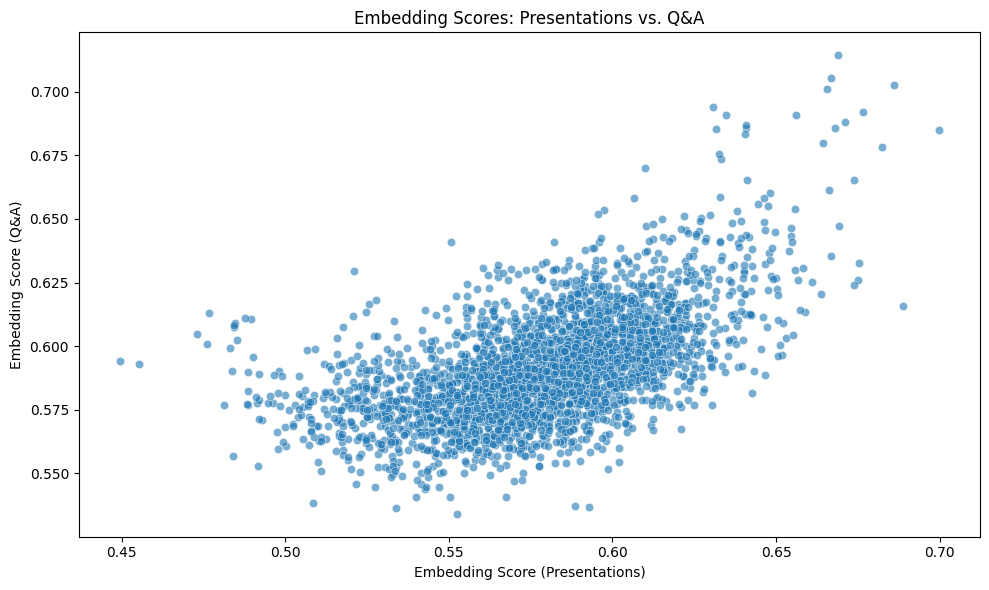

In [48]:
merged_embed_qa = pd.merge(
    Pres[['file_name', 'embed_score']],
    Sample_answers[['file_name', 'embed_score_qa']],
    on='file_name', how='inner'
)

plt.figure(figsize=(10,6))
sns.scatterplot(data=merged_embed_qa, x='embed_score', y='embed_score_qa', alpha=0.6)
plt.xlabel("Embedding Score (Presentations)")
plt.ylabel("Embedding Score (Q&A)")
plt.title("Embedding Scores: Presentations vs. Q&A")
plt.tight_layout()
plt.show()

<u>Comment:</u>
- We see a stronger relationship here between presentation score and Q&A one.
- We observe an increasing Q&A score when Presentation score increases and vice versa.
- This model seems to capture better the relationship between the two: they are quite on the same ground with this embed_score.